In [4]:
import pandas as pd

In [2]:
#Get play-by-play data from 2023 and 2024
from retrieve_sql_module import get_table
pbp_2023 = get_table("statcast_2023")
pbp_2024 = get_table("statcast_2024")

/Users/jaminkim/Desktop/baseball-projects/swing-id/retrieve_sql_module.py:82: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  table = pd.read_sql(query, conn)


In [5]:
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [32]:
def engineer_cs_variables(df):
    df['sz_mid'] = (df['sz_top'] + df['sz_bot']) / 2
    df['plate_relative_z'] = df['plate_z'] - df['sz_mid']
    df['plate_x_standardized'] = df['plate_x']
    df.loc[df['plate_x'] == 1, 'plate_x_standardized'] *= 1
    
    df['stand_L'] = (df['stand'] == 'L').astype(int)
    df['stand_R'] = (df['stand'] == 'R').astype(int)

    df['plate_x_std_L'] = df['plate_x_standardized'] * df['stand_L']
    df['plate_x_std_R'] = df['plate_x_standardized'] * df['stand_R']

    df['plate_relative_z_L'] = df['plate_relative_z'] * df['stand_L']
    df['plate_relative_z_R'] = df['plate_relative_z'] * df['stand_R']

    df['called_strike'] = (df['description'] == "called_strike").astype(int)
    df = calculate_vaa_haa(df)
    return(df)

In [33]:
import numpy as np
def calculate_vaa_haa(df):
    plate_y = 1.5 

    df['vy_f'] = -np.sqrt(df['vy0']**2 - 2 * df['ay'] * (df['release_pos_y'] - plate_y))
    df['t'] = (df['vy_f'] - df['vy0']) / df['ay']
    df['vz_f'] = df['vz0'] + (df['az'] * df['t'])
    df['VAA'] = -np.arctan(df['vz_f'] / df['vy_f']) * (180 / np.pi)
    df['vx_f'] = df['vx0'] + (df['ax'] * df['t'])
    df['HAA'] = -np.arctan(df['vx_f'] / df['vy_f']) * (180 / np.pi)
    return df

In [34]:
pbp_2023

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,spin_dir,spin_rate_deprecated,break_angle_deprecated,break_length_deprecated,zone,des,game_type,stand,p_throws,home_team,away_team,type,hit_location,bb_type,balls,strikes,game_year,pfx_x,pfx_z,plate_x,plate_z,on_3b,on_2b,on_1b,outs_when_up,inning,inning_topbot,hc_x,hc_y,tfs_deprecated,tfs_zulu_deprecated,umpire,sv_id,vx0,vy0,vz0,ax,ay,az,sz_top,sz_bot,hit_distance_sc,launch_speed,launch_angle,effective_speed,release_spin_rate,release_extension,game_pk,fielder_2,fielder_3,fielder_4,fielder_5,fielder_6,fielder_7,fielder_8,fielder_9,release_pos_y,estimated_ba_using_speedangle,estimated_woba_using_speedangle,woba_value,woba_denom,babip_value,iso_value,launch_speed_angle,at_bat_number,pitch_number,pitch_name,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp,bat_speed,swing_length,estimated_slg_using_speedangle,delta_pitcher_run_exp,hyper_speed,home_score_diff,bat_score_diff,home_win_exp,bat_win_exp,age_pit_legacy,age_bat_legacy,age_pit,age_bat,n_thruorder_pitcher,n_priorpa_thisgame_player_at_bat,pitcher_days_since_prev_game,batter_days_since_prev_game,pitcher_days_until_next_game,batter_days_until_next_game,api_break_z_with_gravity,api_break_x_arm,api_break_x_batter_in,arm_angle,sz_mid,plate_relative_z,plate_x_standardized,stand_L,stand_R,plate_x_std_L,plate_x_std_R,plate_relative_z_L,plate_relative_z_R,vy_f,t,vz_f,VAA,vx_f,HAA
0,CH,2023-10-01,89.0,-2.80,5.59,"Robertson, Nick",677008,687798,field_out,hit_into_play,None,None,None,None,9.0,"Heston Kjerstad grounds out, first baseman Bobby Dalbec to pitcher Nick Robertson.",R,L,R,BAL,BOS,X,3.0,ground_ball,2,2,2023,-1.53,0.33,0.33,2.01,NaN,NaN,NaN,2,9,Bot,158.28,166.83,None,None,None,None,11.122985,-129.176025,-3.492080,-19.471845,26.055263,-27.922064,3.81,1.74,6.0,96.4,-17.0,90.7,1703.0,7.4,716367,657136,666915,665839,622569,596115,677800,678882,608701,53.11,0.149,0.145,0.0,1.0,0.0,0.0,2.0,73,6,Changeup,1,6,1,6,6,1,1,6,Infield shade,Standard,250.0,0.0,-0.233,66.5,6.5,0.157,0.233,96.4,-5,-5,0.0,0.0,24,24,25,24,1,3,11.0,1.0,NaN,NaN,2.55,1.53,-1.53,31.7,2.775,-0.765,0.33,1,0,0.33,0.0,-0.765,-0.0,-118.309007,0.417076,-15.137695,-7.291405,3.001751,1.453404
1,FF,2023-10-01,96.9,-2.40,5.90,"Robertson, Nick",677008,687798,None,foul,None,None,None,None,5.0,"Heston Kjerstad grounds out, first baseman Bobby Dalbec to pitcher Nick Robertson.",R,L,R,BAL,BOS,S,NaN,None,2,2,2023,-0.76,1.36,0.09,2.71,NaN,NaN,NaN,2,9,Bot,NaN,NaN,None,None,None,None,8.558215,-140.741874,-6.148396,-12.116762,34.259201,-12.836434,3.81,1.74,223.0,78.2,56.0,98.4,2153.0,7.4,716367,657136,666915,665839,622569,596115,677800,678882,608701,53.13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,73,5,4-Seam Fastball,1,6,1,6,6,1,1,6,Infield shade,Standard,211.0,0.0,0.000,70.8,6.7,NaN,0.000,88.0,-5,-5,0.0,0.0,24,24,25,24,1,3,11.0,1.0,NaN,NaN,1.09,0.76,-0.76,47.4,2.775,-0.065,0.09,1,0,0.09,0.0,-0.065,-0.0,-127.556537,0.384870,-11.088754,-4.968350,3.894837,1.748938
2,CH,2023-10-01,90.0,-2.93,5.56,"Robertson, Nick",677008,687798,None,ball,None,None,None,None,13.0,"Heston Kjerstad grounds out, first baseman Bobby Dalbec to pitcher Nick Robertson.",R,L,R,BAL,BOS,B,NaN,None,1,2,2023,-1.65,0.36,-0.24,0.53,NaN,NaN,NaN,2,9,Bot,NaN,NaN,None,None,None,None,10.328033,-130.515462,-7.371558,-20.978432,27.339657,-26.599717,3.71,1.78,NaN,NaN,NaN,91.5,1698.0,7.4,716367,657136,666915,665839,622569,596115,677800,678882,608701,53.14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,73,4,Changeup,1,6,1,6,6,1,1,6,Infield shade,Standard,250.0,0.0,0.041,NaN,NaN,NaN,-0.041,NaN,-5,-5,0.0,0.0,24,24,25,24,1,3,11.0,1.0,NaN,NaN,2.47,1.65,-1.65,30.3,2.745,-2.215,-0.24,1,0,-0.24,-0.0,-2.215,-0.0,-119.208415,0.413577,-18.372584,-8.761575,1.651841,0.793882
3,ST,2023-10-01,82.2,-3.09,5.55,"Robertson, Nick",677008,687798,None,ball,None,None,None,None,14.0,"Heston

In [35]:
pbp_2023 = engineer_cs_variables(pbp_2023)
pbp_2024 = engineer_cs_variables(pbp_2024)

In [47]:
ball_cs_2023 = pbp_2023[pbp_2023['description'].isin(["called_strike", "ball"])]
ball_cs_2024 = pbp_2024[pbp_2024['description'].isin(["called_strike", "ball"])]
ball_cs_2023 = ball_cs_2023.dropna(subset=["plate_x_std_L", "plate_x_std_R", "plate_relative_z_L", "plate_relative_z_R", "VAA", "HAA"])
ball_cs_2024 = ball_cs_2024.dropna(subset=["plate_x_std_L", "plate_x_std_R", "plate_relative_z_L", "plate_relative_z_R", "VAA", "HAA"])

In [55]:
print(ball_cs_2023.shape)
print(ball_cs_2024.shape)

(358481, 129)
(351516, 129)


In [83]:
from pygam import LogisticGAM, s, te
X = ball_cs_2023[["plate_x", "plate_z"]]
y = ball_cs_2023["called_strike"]
cs_gam_dummy = LogisticGAM(
    te(0,1)
)

cs_gam_dummy.fit(X,y)

/Users/jaminkim/anaconda3/envs/pygam_env/lib/python3.10/site-packages/pygam/links.py:149: RuntimeWarning: divide by zero encountered in divide
  return dist.levels / (mu * (dist.levels - mu))
/Users/jaminkim/anaconda3/envs/pygam_env/lib/python3.10/site-packages/pygam/pygam.py:627: RuntimeWarning: invalid value encountered in multiply
  self.link.gradient(mu, self.distribution) ** 2


LogisticGAM(callbacks=[Deviance(), Diffs(), Accuracy()], 
   fit_intercept=True, max_iter=100, terms=te(0, 1) + intercept, 
   tol=0.0001, verbose=False)

In [93]:
from pygam import LogisticGAM, s, te

X = ball_cs_2023[["plate_x_std_L", "plate_x_std_R", "plate_relative_z_L", "plate_relative_z_R", "VAA", "HAA"]]
y = ball_cs_2023["called_strike"]
cs_gam = LogisticGAM(
    te(0,1) +
    te(2,3) +
    s(4) +
    s(5)
)

cs_gam.fit(X,y)

LogisticGAM(callbacks=[Deviance(), Diffs(), Accuracy()], 
   fit_intercept=True, max_iter=100, 
   terms=te(0, 1) + te(2, 3) + s(4) + s(5) + intercept, tol=0.0001, 
   verbose=False)

In [66]:
print(ball_cs_2023['called_strike'].value_counts())
print(ball_cs_2024['called_strike'].value_counts())

called_strike
0    240589
1    117892
Name: count, dtype: int64
called_strike
0    235460
1    116056
Name: count, dtype: int64


In [86]:
X_2024_naive = ball_cs_2024[['plate_x', 'plate_z']]
y_2024_naive = ball_cs_2024['called_strike']

In [91]:
X_2024 = ball_cs_2024[['plate_x_std_L', 'plate_x_std_R', 'plate_relative_z_L', 'plate_relative_z_R', 'VAA', 'HAA']]
y_2024 = ball_cs_2024['called_strike']

In [88]:
y_pred_probs_naive = cs_gam_dummy.predict_proba(X_2024_naive)
y_pred_labels_naive = (y_pred_probs > 0.5).astype(int)

In [92]:
y_pred_probs = cs_gam.predict_proba(X_2024)
y_pred_labels = (y_pred_probs > 0.5).astype(int)

ValueError: X data must have 2 features, but found 6

In [89]:
from sklearn.metrics import log_loss, roc_auc_score, accuracy_score

logloss_naive = log_loss(y_2024, y_pred_probs_naive)
roc_auc_naive = roc_auc_score(y_2024, y_pred_probs_naive)
accuracy_naive = accuracy_score(y_2024, y_pred_labels_naive)

print(f"Accuracy on 2024 data: {accuracy_naive:.5f}")
print(f"Log Loss: {logloss_naive:.5f}")
print(f"Full AUC: {roc_auc_naive:.10f}")

Accuracy on 2024 data: 0.91805
Log Loss: 0.18160
Full AUC: 0.9784367064


In [78]:
from sklearn.metrics import log_loss, roc_auc_score, accuracy_score

logloss = log_loss(y_2024, y_pred_probs)
roc_auc = roc_auc_score(y_2024, y_pred_probs)
accuracy = accuracy_score(y_2024, y_pred_labels)

print(f"Accuracy on 2024 data: {accuracy:.5f}")
print(f"Log Loss: {logloss:.5f}")
print(f"Full AUC: {roc_auc:.10f}")

Accuracy on 2024 data: 1.00000
Log Loss: 0.11349
Full AUC: 1.0000000000


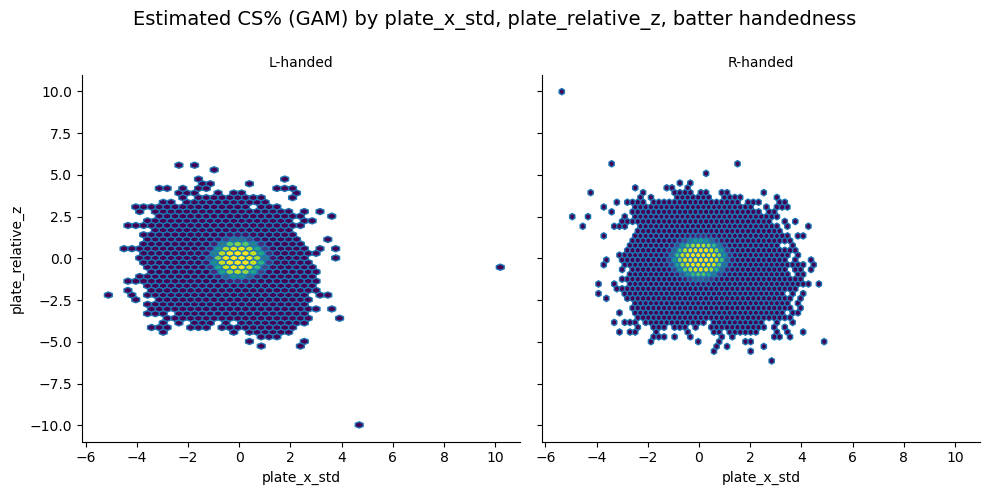

In [73]:
import seaborn as sns
import matplotlib.pyplot as plt
ball_cs_2024['cs_prob'] = y_pred_probs  # placeholder for cs_gam.predict_proba(X_2024)

# Recompute merged plotting columns
ball_cs_2024['plate_x_std'] = ball_cs_2024['plate_x_std_L'] + ball_cs_2024['plate_x_std_R']
ball_cs_2024['plate_relative_z'] = ball_cs_2024['plate_relative_z_L'] + ball_cs_2024['plate_relative_z_R']

# Subset columns for plotting
ball_cs_plot = ball_cs_2024[['plate_x_std', 'plate_relative_z', 'stand', 'cs_prob']].copy()

# Plot with updated data
g = sns.FacetGrid(ball_cs_plot, col="stand", col_order=["L", "R"], height=5, aspect=1)
g.map_dataframe(
    plt.hexbin,
    x="plate_x_std",
    y="plate_relative_z",
    C="cs_prob",
    reduce_C_function=np.mean,
    gridsize=50,
    cmap="viridis"
)
g.set_axis_labels("plate_x_std", "plate_relative_z")
g.set_titles(col_template="{col_name}-handed")
plt.subplots_adjust(top=0.85)
g.fig.suptitle("Estimated CS% (GAM) by plate_x_std, plate_relative_z, batter handedness", fontsize=14)
plt.show()

In [75]:
ball_cs_2024_filtered = ball_cs_2024[(ball_cs_2024['cs_prob'] > 0.4) & (ball_cs_2024['cs_prob'] < 0.6)]
ball_cs_2024_filtered

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,spin_dir,spin_rate_deprecated,break_angle_deprecated,break_length_deprecated,zone,des,game_type,stand,p_throws,home_team,away_team,type,hit_location,bb_type,balls,strikes,game_year,pfx_x,pfx_z,plate_x,plate_z,on_3b,on_2b,on_1b,outs_when_up,inning,inning_topbot,hc_x,hc_y,tfs_deprecated,tfs_zulu_deprecated,umpire,sv_id,vx0,vy0,vz0,ax,ay,az,sz_top,sz_bot,hit_distance_sc,launch_speed,launch_angle,effective_speed,release_spin_rate,release_extension,game_pk,fielder_2,fielder_3,fielder_4,fielder_5,fielder_6,fielder_7,fielder_8,fielder_9,release_pos_y,estimated_ba_using_speedangle,estimated_woba_using_speedangle,woba_value,woba_denom,babip_value,iso_value,launch_speed_angle,at_bat_number,pitch_number,pitch_name,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp,bat_speed,swing_length,estimated_slg_using_speedangle,delta_pitcher_run_exp,hyper_speed,home_score_diff,bat_score_diff,home_win_exp,bat_win_exp,age_pit_legacy,age_bat_legacy,age_pit,age_bat,n_thruorder_pitcher,n_priorpa_thisgame_player_at_bat,pitcher_days_since_prev_game,batter_days_since_prev_game,pitcher_days_until_next_game,batter_days_until_next_game,api_break_z_with_gravity,api_break_x_arm,api_break_x_batter_in,arm_angle,sz_mid,plate_relative_z,plate_x_standardized,stand_L,stand_R,plate_x_std_L,plate_x_std_R,plate_relative_z_L,plate_relative_z_R,vy_f,t,vz_f,VAA,vx_f,HAA,called_strike,cs_prob,plate_x_std
37,FF,2024-09-30,97.4,-2.15,6.14,"Johnson, Pierce",516782,572955,None,called_strike,None,None,None,None,2.0,Starling Marte singles on a ground ball to left fielder Ramón Laureano.,R,R,R,ATL,NYM,S,NaN,None,0,0,2024,-0.67,1.49,0.06,3.52,NaN,NaN,NaN,1,9,Top,NaN,NaN,None,None,None,None,7.408409,-141.678329,-4.953052,-10.724915,30.585453,-11.062243,3.48,1.58,NaN,NaN,NaN,97.0,2428.0,6.0,747139,518595,621566,645277,593160,570482,657656,671739,642201,54.54,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75,1,4-Seam Fastball,7,6,6,7,6,7,6,7,Standard,Standard,219.0,0.000,-0.037,NaN,NaN,NaN,0.037,NaN,1,-1,0.913,0.087,33,35,33,36,1,1,2.0,1.0,2.0,0.0,0.90,0.67,0.67,40.1,2.530,0.990,0.06,0,1,0.00,0.06,0.00,0.990,-129.723722,0.390859,-9.276832,-4.090385,3.216477,1.420348,1,0.591529,0.06
49,FF,2024-09-30,97.7,-2.07,4.96,"Díaz, Edwin",645277,621242,None,ball,None,None,None,None,12.0,Ozzie Albies doubles (29) on a sharp line drive to left fielder Brandon Nimmo. Travis d'Arnaud scores. Whit Merrifield scores. Michael Harris II scores.,R,R,R,ATL,NYM,B,NaN,None,1,0,2024,-0.97,0.99,0.16,3.37,518595.0,593160.0,671739.0,2,8,Bot,NaN,NaN,None,None,None,None,8.424911,-142.190202,-1.109040,-15.013936,30.506687,-18.622732,3.18,1.52,NaN,NaN,NaN,100.1,2291.0,7.5,747139,682626,624413,657193,578428,596019,607043,621438,516782,53.02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,72,2,4-Seam Fastball,4,6,4,6,6,4,4,6,Standard,Standard,229.0,0.000,0.088,NaN,NaN,NaN,-0.088,NaN,-2,-2,0.221,0.221,30,27,30,27,1,4,1.0,1.0,3.0,0.0,1.38,0.97,0.97,21.2,2.350,1.020,0.16,0,1,0.00,0.16,0.00,1.020,-130.669983,0.377629,-8.141530,-3.565265,2.755209,1.207917,0,0.423470,0.16
61,FF,2024-09-30,95.8,-2.06,5.09,"Díaz, Edwin",570482,621242,None,ball,None,None,None,None,3.0,"Gio Urshela grounds out softly, pitcher Edwin Díaz to first baseman Pete Alonso. Travis d'Arnaud to 2nd.",R,R,R,ATL,NYM,B,NaN,None,0,0,2024,-0.92,1.19,0.65,3.18,642201.0,NaN,518595.0,1,8,Bot,NaN,NaN,None,None,None,None,9.415938,-139.334259,-2.206500,-13.889636,27.317166,-16.271588,3.40,1.53,NaN,NaN,NaN,98.1,2365.0,7.3,747139,682626,624413,657193,578428,596019,607043,621438,516782,53.18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,69,1,4-Seam Fastball,3,6,3,6,6,3,3,6,Standard,Standard,228.0,0.000,0.024,NaN,NaN,NaN,-0.024,NaN,-3,-3,0.149,0.149,30,32,30,33,1,3,1.0,1.0,3.0,0.0,1.27,0.92,0.92,22.4,2.465,0.715,0.65,0,1,0.00,0.65,0.00,0.715,-128.804244,0.385472,-8.478749,-3.766

In [94]:
import pickle

with open('cs_gam_model.pkl', 'wb') as f:
    pickle.dump(cs_gam, f)